## Title: Forecasting Spare parts inventory
### Client: NewX Services
### Project Ref: PM-PR-0027

#### Business Case: The case business case is on the inventory management. Keeping Inventory of spare in various service centre to the market demand is always a challenge as most service centres spends significant amount in spare parts inventory costs. In spite of this, availability of spare parts is been one of the problem areas.

### GOAL: Create Predictive model for inventory forecasting so that service centre achieve JIT standards.¶

## Approach: Neural Network - Feed forward mechanism 

In [1]:
# !pip install sqlalchemy
# !pip install pymysql

In [2]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt


import numpy as np
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,12

import math

from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## DB Connection

In [3]:
db_host = '18.136.157.135'
username = 'dm_usdata_sql'
user_pass = '37z<49REb&mKnl4AV!vJ'
db_name = 'project_service_data'

conn = create_engine('mysql+pymysql://'+username+':'+user_pass+'@'+db_host+'/'+db_name)
conn.table_names()

['service_data']

In [4]:
# Querying Table

query = "SELECT * FROM service_data"                                         
service = pd.read_sql(query,conn)
service.head(5)

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
0,30-05-17,30-05-17,shivXXXXXXXXXX,KA03MFXXXX,BAJAJ AVENGER STREET 220,50000,ENGINE OIL
1,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,ENGINE OIL
2,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,POLISH
3,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,CONSUMABLES
4,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,COOLANT OIL


## The time Series model takes only two parameters, one variable and volume

## In our problem we consider Job card date as variable and since there is no volume provided we take sum of spares used per day as our target.


In [5]:
# Object to datetime data type conversion
# Grouping by date and again grouping by date to have equal interval of time series data
# Sort and set date as index...

dataframe=service.loc[:,['job_card_date', 'invoice_line_text']]
dataframe.rename(columns={"job_card_date": "date", "invoice_line_text": "spares"}, inplace=True)
dataframe["date"] = pd.to_datetime(dataframe["date"].astype(str),format='%d/%m/%Y',dayfirst=True,infer_datetime_format=True)
dt_grp_df = dataframe.groupby(['date'], sort=False).count()
df = pd.DataFrame(dt_grp_df)
df.head()

,spares
date,
2017-05-30,1
2017-05-31,40
2017-06-01,49
2017-06-02,16
2017-06-03,40


In [6]:
dataframe=df.loc[:,['spares']]

In [7]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 553 entries, 2017-05-30 to 2019-01-06
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   spares  553 non-null    int64
dtypes: int64(1)
memory usage: 8.6 KB


## Plot of grouped and sorted input

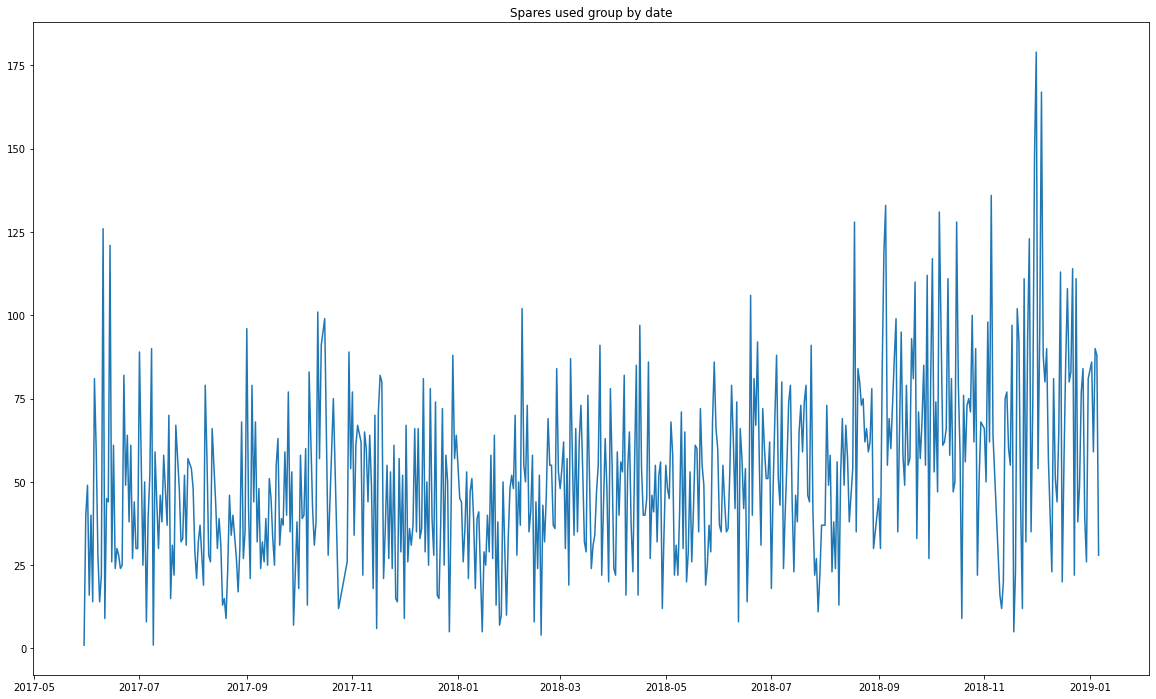

In [8]:
plt.plot(dataframe,label='Consumption')
plt.title('Spares used group by date')
plt.show(block=False)

In [9]:
# Conversion of values into float
dataset = dataframe.values
dataset = dataset.astype('float32')

In [10]:
# Normalization for neural network activation functions are sensitive to magnitude of numbers.
scaler = MinMaxScaler(feature_range=(0, 1)) # from sklearn.preprocessing
dataset = scaler.fit_transform(dataset)

## Train and test split

In [11]:
# sequencing the data for time series modeling
# first 2/3 values goes to train and the remaining 1/3 for testing
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [12]:
train

array([[0.        ],
       [0.21910113],
       [0.26966292],
       [0.08426967],
       [0.21910113],
       [0.07303371],
       [0.4494382 ],
       [0.33146068],
       [0.1516854 ],
       [0.07303371],
       [0.11797753],
       [0.7022472 ],
       [0.04494382],
       [0.24719101],
       [0.24157304],
       [0.6741573 ],
       [0.14044943],
       [0.33707866],
       [0.12921348],
       [0.16292135],
       [0.1516854 ],
       [0.12921348],
       [0.13483146],
       [0.4550562 ],
       [0.26966292],
       [0.3539326 ],
       [0.20786518],
       [0.33707866],
       [0.14606743],
       [0.24157304],
       [0.16292135],
       [0.16292135],
       [0.49438202],
       [0.13483146],
       [0.2752809 ],
       [0.03932584],
       [0.21348315],
       [0.28651685],
       [0.5       ],
       [0.        ],
       [0.3258427 ],
       [0.24157304],
       [0.16292135],
       [0.252809  ],
       [0.20786518],
       [0.32022473],
       [0.20224719],
       [0.387

In [13]:
test

array([[0.4494382 ],
       [0.37078652],
       [0.51123595],
       [0.31460676],
       [0.16853933],
       [0.3988764 ],
       [0.33146068],
       [0.28089887],
       [0.28089887],
       [0.34269664],
       [0.09550562],
       [0.26404494],
       [0.38202247],
       [0.48876405],
       [0.28089887],
       [0.23595506],
       [0.44382024],
       [0.12921348],
       [0.2247191 ],
       [0.30898878],
       [0.41011235],
       [0.43820226],
       [0.24157304],
       [0.12359551],
       [0.252809  ],
       [0.20786518],
       [0.35955057],
       [0.40449437],
       [0.3258427 ],
       [0.41011235],
       [0.43820226],
       [0.252809  ],
       [0.24157304],
       [0.505618  ],
       [0.2247191 ],
       [0.11797753],
       [0.14606743],
       [0.05617978],
       [0.11797753],
       [0.20224719],
       [0.20224719],
       [0.20224719],
       [0.40449437],
       [0.26966292],
       [0.32022473],
       [0.12359551],
       [0.20786518],
       [0.129

## Build the model

In [14]:
# Definition of FFNN function to construct multipe input as feed in and get one output
# So let us convert an array of values into a dataset matrix
# below the seq_size is the number of previous time steps to use as input variables to predict the next time period
# here X is the number of spares at a given time (t, t-1, t-2...) 
# and Y is the number of spares at the next time (t + 1) to teach the model in a FFNN way ;-)

def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)

In [15]:
seq_size = 10 # Number of time steps of sequenced value to look back (Feed dorward) 
#Larger sequences (look further back) might improve forecasting

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

#Compare trainX and dataset. You can see that X= values at t, t+1 and t+2
#whereas Y is the value that follows, t+3 (since our sequence size is 3)

print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

Shape of training set: (353, 10)
Shape of test set: (178, 10)


In [16]:
#Input dimensions are... (N x seq_size)
print('Build deep model...')
# create and fit dense model
model = Sequential()
model.add(Dense(64, input_dim=seq_size, activation='relu'))
model.add(Dense(32, activation='relu')) # single dense layer
model.add(Dense(1)) # output dense layer
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['acc']) # error scoring
print(model.summary()) 

Build deep model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                704       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None


## Training the model

In [17]:
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)

Epoch 1/100
12/12 - 21s - loss: 0.0302 - acc: 0.0028 - val_loss: 0.0391 - val_acc: 0.0056
Epoch 2/100
12/12 - 0s - loss: 0.0184 - acc: 0.0028 - val_loss: 0.0387 - val_acc: 0.0000e+00
Epoch 3/100
12/12 - 0s - loss: 0.0176 - acc: 0.0028 - val_loss: 0.0322 - val_acc: 0.0000e+00
Epoch 4/100
12/12 - 0s - loss: 0.0158 - acc: 0.0028 - val_loss: 0.0333 - val_acc: 0.0000e+00
Epoch 5/100
12/12 - 0s - loss: 0.0156 - acc: 0.0028 - val_loss: 0.0317 - val_acc: 0.0000e+00
Epoch 6/100
12/12 - 0s - loss: 0.0153 - acc: 0.0028 - val_loss: 0.0319 - val_acc: 0.0000e+00
Epoch 7/100
12/12 - 0s - loss: 0.0155 - acc: 0.0028 - val_loss: 0.0335 - val_acc: 0.0000e+00
Epoch 8/100
12/12 - 0s - loss: 0.0148 - acc: 0.0028 - val_loss: 0.0323 - val_acc: 0.0000e+00
Epoch 9/100
12/12 - 0s - loss: 0.0151 - acc: 0.0028 - val_loss: 0.0315 - val_acc: 0.0000e+00
Epoch 10/100
12/12 - 0s - loss: 0.0147 - acc: 0.0028 - val_loss: 0.0323 - val_acc: 0.0000e+00
Epoch 11/100
12/12 - 0s - loss: 0.0147 - acc: 0.0028 - val_loss: 0.0307 

Epoch 89/100
12/12 - 0s - loss: 0.0091 - acc: 0.0028 - val_loss: 0.0391 - val_acc: 0.0000e+00
Epoch 90/100
12/12 - 0s - loss: 0.0095 - acc: 0.0028 - val_loss: 0.0487 - val_acc: 0.0000e+00
Epoch 91/100
12/12 - 0s - loss: 0.0096 - acc: 0.0028 - val_loss: 0.0377 - val_acc: 0.0000e+00
Epoch 92/100
12/12 - 0s - loss: 0.0089 - acc: 0.0028 - val_loss: 0.0461 - val_acc: 0.0000e+00
Epoch 93/100
12/12 - 0s - loss: 0.0093 - acc: 0.0028 - val_loss: 0.0354 - val_acc: 0.0000e+00
Epoch 94/100
12/12 - 0s - loss: 0.0102 - acc: 0.0028 - val_loss: 0.0453 - val_acc: 0.0000e+00
Epoch 95/100
12/12 - 0s - loss: 0.0087 - acc: 0.0028 - val_loss: 0.0407 - val_acc: 0.0000e+00
Epoch 96/100
12/12 - 0s - loss: 0.0091 - acc: 0.0028 - val_loss: 0.0426 - val_acc: 0.0000e+00
Epoch 97/100
12/12 - 0s - loss: 0.0096 - acc: 0.0028 - val_loss: 0.0408 - val_acc: 0.0000e+00
Epoch 98/100
12/12 - 0s - loss: 0.0092 - acc: 0.0028 - val_loss: 0.0443 - val_acc: 0.0000e+00
Epoch 99/100
12/12 - 0s - loss: 0.0091 - acc: 0.0028 - val_l

## The accuracy seems good

## Prediction

In [18]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

## Evaluation

In [19]:
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.

trainPredict = scaler.inverse_transform(trainPredict)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform([testY])

In [20]:
# Real sum of predicted spares after inverst transformation
testY_inverse

array([[ 17.99999975,  47.99999892,  68.99999901,  87.99999959,
         50.99999818,  43.00000017,  80.00000157,  23.99999959,
         41.00000066,  56.00000224,  73.99999776,  79.00000182,
         43.99999992,  22.99999983,  45.99999942,  38.00000141,
         65.        ,  72.99999801,  59.00000149,  73.99999776,
         79.00000182,  45.99999942,  43.99999992,  90.99999884,
         41.00000066,  22.00000008,  27.00000149,  11.00000017,
         22.00000008,  36.99999901,  36.99999901,  36.99999901,
         72.99999801,  48.99999867,  58.00000174,  22.99999983,
         38.00000141,  23.99999959,  56.00000224,  12.99999967,
         51.99999793,  68.99999901,  48.99999867,  66.9999995 ,
         57.00000199,  38.00000141,  54.00000274, 128.00000025,
         34.9999995 ,  84.00000058,  80.00000157,  72.99999801,
         75.00000282,  62.00000075,  65.99999975,  59.00000149,
         62.00000075,  78.00000207,  30.00000075,  44.99999967,
         30.00000075,  83.00000083, 119.

In [21]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_inverse[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY_inverse[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 17.29 RMSE
Test Score: 40.72 RMSE


## Root mean squared error is good, not very bad

In [22]:
# shift train predictions for plotting
# we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

In [23]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

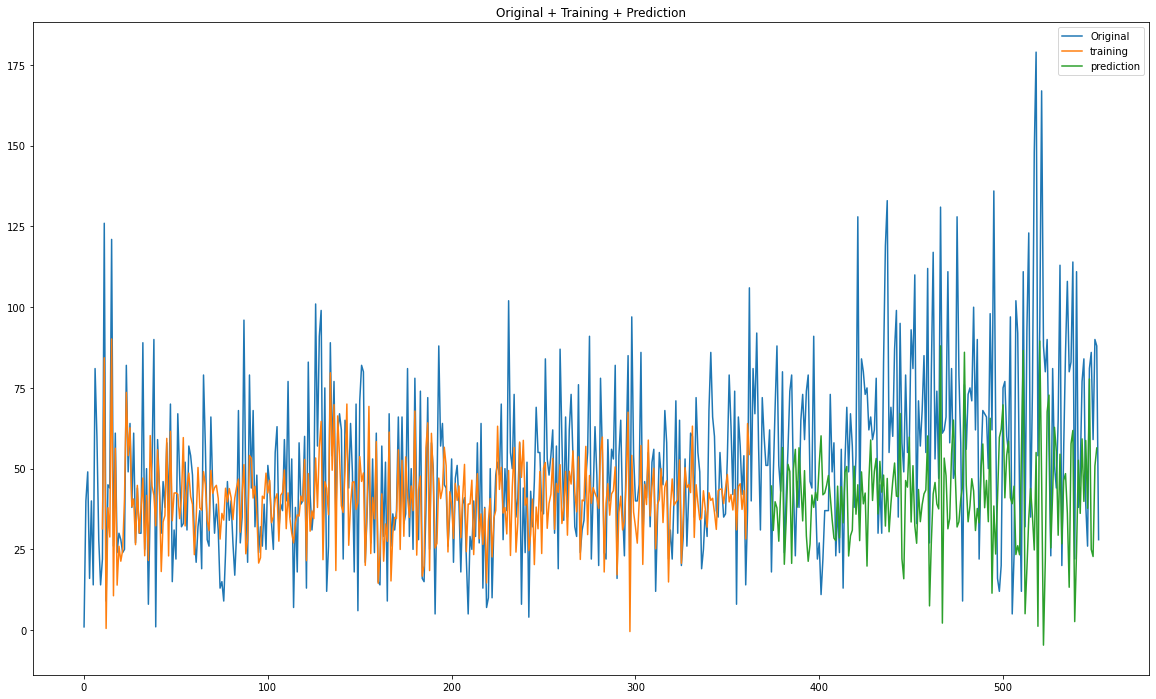

In [24]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label='Original')
plt.plot(trainPredictPlot, label='training')
plt.plot(testPredictPlot, label='prediction')
plt.legend(loc='best')
plt.title('Original + Training + Prediction')
plt.show(block=False)

In [25]:
results = pd.DataFrame(testPredictPlot)
results.dropna(inplace=True)
print(results)

             0
374  44.614143
375  30.854706
376  39.751194
377  37.815498
378  27.526628
..         ...
547  77.780586
548  24.991972
549  22.791977
550  50.846966
551  56.392220

[178 rows x 1 columns]


# Results: Root mean squared error is good with good accuracy